In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import make_regression as MR
from sklearn.linear_model import LinearRegression as LR, Lasso as LLR
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

import torchvision
from torchvision import *
from torch.nn import *
from NN import NN, ClassificationReport

from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
 
from sklearn import datasets
from random import shuffle


In [2]:
def SSUM(df,columns):
    if(columns  != []):
        return (df[columns[0]]+SSUM(df,columns[1:]))
    return ''

categoricals=['sex','cp','fbs','restecg','exng','slp','caa','thall']
df=pd.read_csv('heart.csv')
X=df.drop(['output'],axis=1).applymap(str)
Y=df[['output']].to_numpy()
Y=Y.reshape(-1)

X['categoricals']=SSUM(X,categoricals)
X=X.drop(categoricals,axis=1).to_numpy()[:,::-1]

In [3]:
grid=[(0,0),(0,65),(0,130),(0,195),(140,100),(140,175)]
font_size=[50]*6

In [4]:
def sampletoimage(sample):
 img =  Image.fromarray(np.zeros((255,255)).astype('uint8'))
 draw = ImageDraw.Draw(img)    
 for f,s,g in zip(font_size,sample,grid):
  font = ImageFont.truetype("./font.ttf", size=f)
  draw.text(g,str(s),font=font, fill='white')

 return [np.array(img) for _ in range(3)]

In [5]:
X=np.array(list(map(sampletoimage,X)))

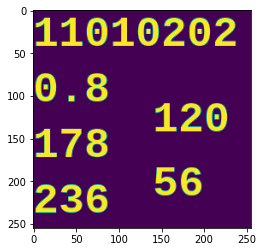

In [6]:
plt.imshow(X[3,0])

### Neural Network

In [7]:
device='cuda:0'
net = NN(model=models.resnet18(pretrained=True),
         cut=1,
         add=Sequential(Sequential(Linear(512,100),ReLU(),Linear(100,2)),Softmax(dim=1)),
         gradients=10)
net=net.to(device)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, shuffle=True)

train_data = torch.utils.data.DataLoader(list(zip(X_train,Y_train)), batch_size=32, shuffle=True, drop_last=True,num_workers=2)
validation_data = torch.utils.data.DataLoader(list(zip(X_val,Y_val)),batch_size=1,num_workers=2) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

net.optimization(criterion,optimizer)
Train_stats, Test_stats = net.TRAIN(train_data,validation_data, 
                                    epochs=30, 
                                    batch_size=32,
                                    verbose=1,
                                    random_seed=1,
                                    device=device)

#net.save()

-----      TRAIN RESULTS      -----
{'Epoch': 1.0, 'Accuracy': 0.4895833333333333, 'Loss': 0.6991417606671652}
-----      Validation  RESULTS     -----
{'Epoch': 1.0, 'Accuracy': 0.5714285714285714, 'Loss': 0.6912778287517781}
-----      TRAIN RESULTS      -----
{'Epoch': 2.0, 'Accuracy': 0.5833333333333334, 'Loss': 0.6680226723353068}
-----      Validation  RESULTS     -----
{'Epoch': 2.0, 'Accuracy': 0.5918367346938775, 'Loss': 0.674888267809031}
-----      TRAIN RESULTS      -----
{'Epoch': 3.0, 'Accuracy': 0.75, 'Loss': 0.6278662085533142}
-----      Validation  RESULTS     -----
{'Epoch': 3.0, 'Accuracy': 0.5918367346938775, 'Loss': 0.6656290256247228}
-----      TRAIN RESULTS      -----
{'Epoch': 4.0, 'Accuracy': 0.8385416666666666, 'Loss': 0.5750338931878408}
-----      Validation  RESULTS     -----
{'Epoch': 4.0, 'Accuracy': 0.7551020408163265, 'Loss': 0.6186617758809304}
-----      TRAIN RESULTS      -----
{'Epoch': 5.0, 'Accuracy': 0.8229166666666666, 'Loss': 0.52545602619647

## Visualization

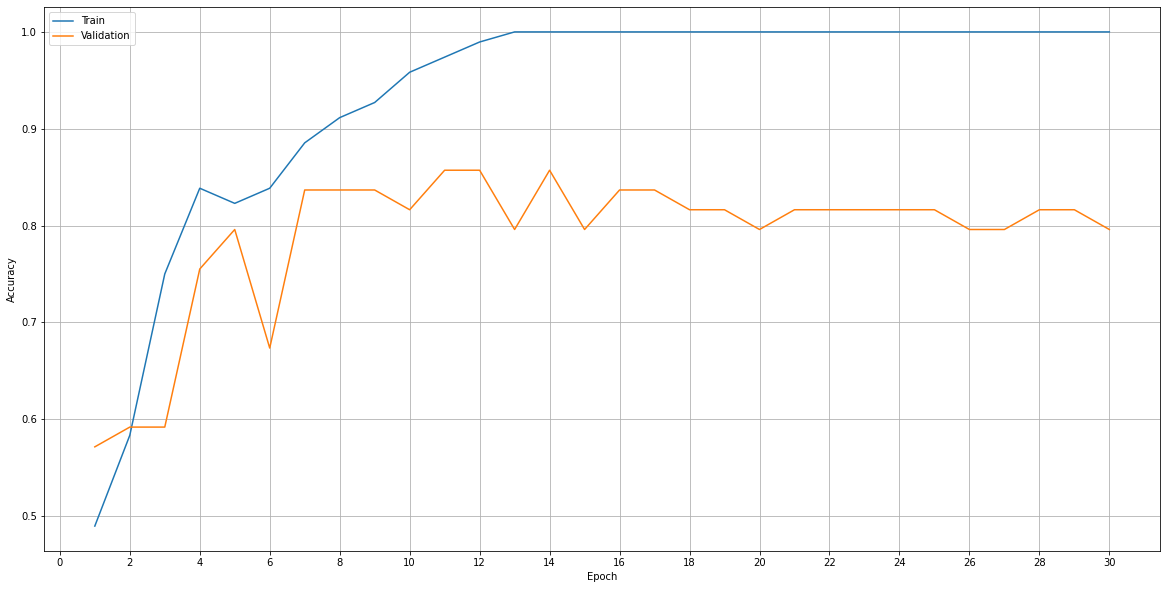

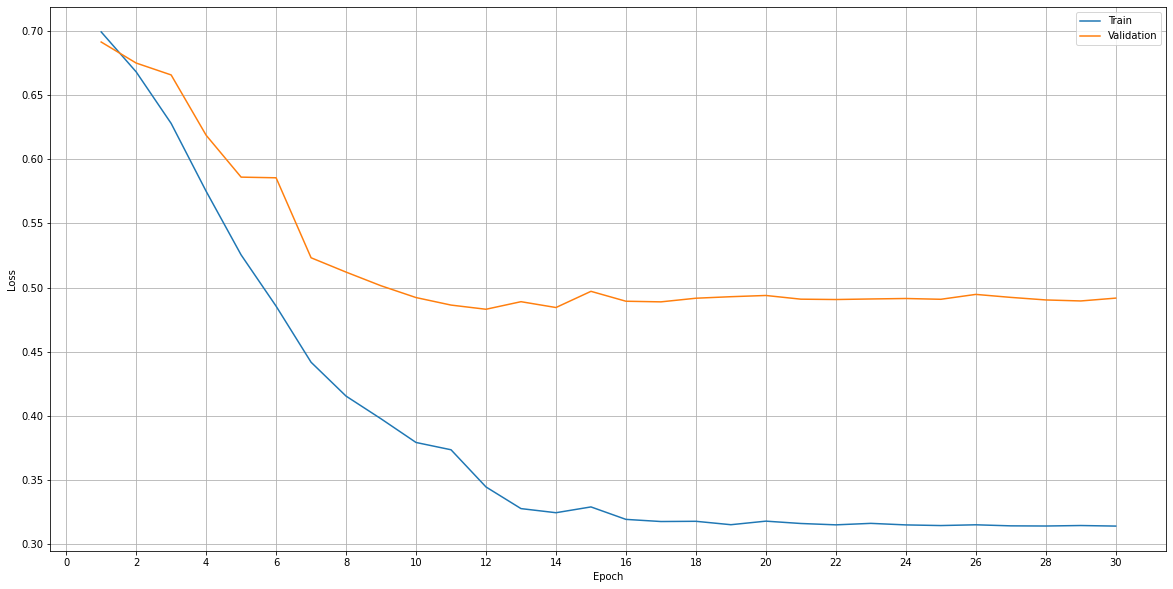

In [9]:
net.plot('Accuracy')
net.plot('Loss')

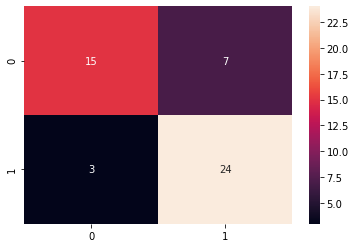

In [10]:
report=ClassificationReport(net)
report.fit(X_val,Y_val)
report.heatmap()

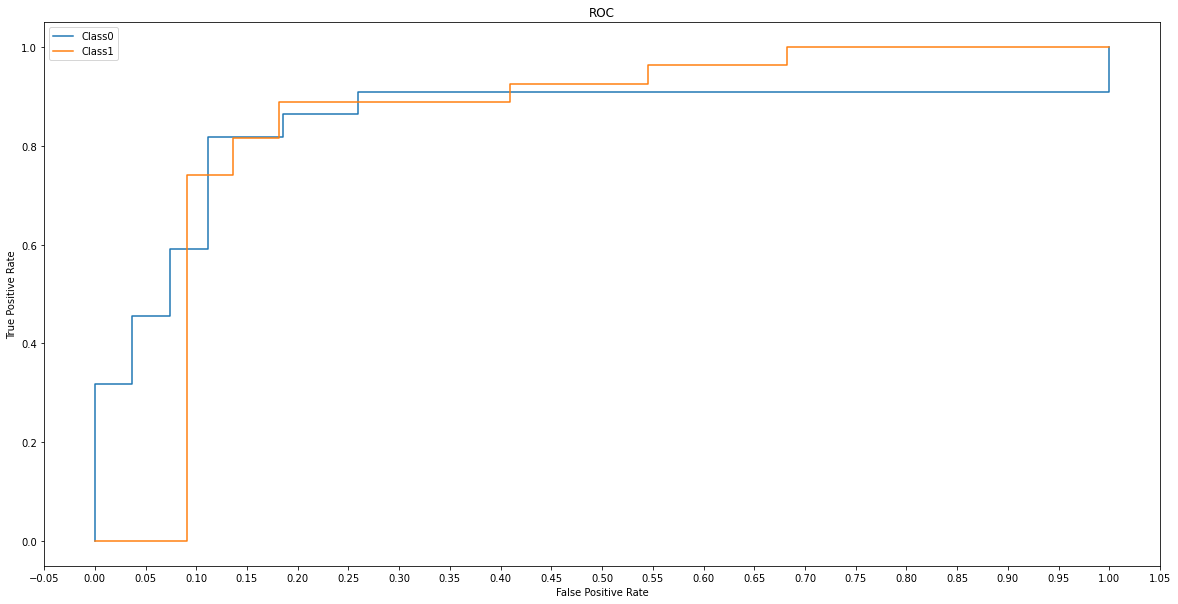

In [11]:
report.plot_ROC()

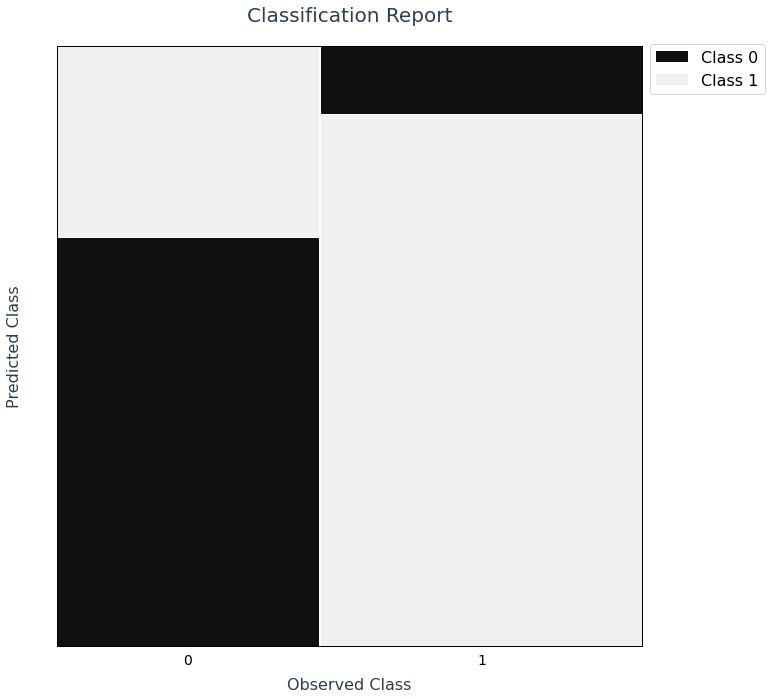

In [12]:
report.mosaic_plot()

In [13]:
report.print_AUC()

Clas_0: 0.8484848484848484
Clas_1: 0.8484848484848484


In [14]:
print("CROSS ENTROPY:",report.cross_entropy())
print("Accuracy:",report.accuracy())

CROSS ENTROPY: 0.8829685650539246
Accuracy: 0.7959183673469388


### TESTING OUR PERFORMANCE

In [15]:
device='cuda:0'
net = NN(model=models.resnet18(pretrained=True),
         cut=1,
         add=Sequential(Sequential(Linear(512,100),ReLU(),Linear(100,2)),Softmax(dim=1)),
         gradients=10)
net=net.to(device)
net.load()

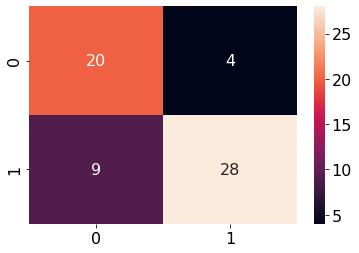

In [16]:
report=ClassificationReport(net)
report.fit(X_test,Y_test)
report.heatmap()

In [17]:
report.print_AUC()

Clas_0: 0.8581081081081081
Clas_1: 0.8581081081081081


In [18]:
print("CROSS ENTROPY:",report.cross_entropy())
print("Accuracy:",report.accuracy())

CROSS ENTROPY: 0.9737686462195358
Accuracy: 0.7868852459016393


### XGBOOST

In [19]:
X=df.drop('output',axis=1)
X=X.to_numpy()

In [20]:
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import log_loss as Loss
from sklearn.metrics import confusion_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11, shuffle=True)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1, shuffle=True)

model=XGBR(n_estimators = 10,n_jobs=-1).fit(X_train,Y_train)
P=model.predict(X_test)

In [21]:
MD = [1,2,3,4,5]
Scores=[]
for md in MD:
 model=XGBR(n_estimators = 10,n_jobs=-1,max_depth=md).fit(X_train,Y_train)
 Score=sum(Y_val==(model.predict(X_val)>0.5))/len(Y_test)
 Scores.append(Score)

In [22]:
md=MD[np.argmax(np.asarray(Scores))]
print(f"MD:{md}")
model=XGBR(n_estimators = 10,n_jobs=-1,max_depth=md).fit(X_train,Y_train)

MD:1


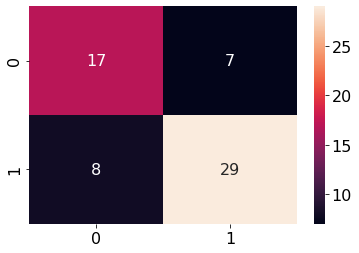

In [23]:
report=ClassificationReport(model)
report.fit(X_test,Y_test)
report.heatmap()

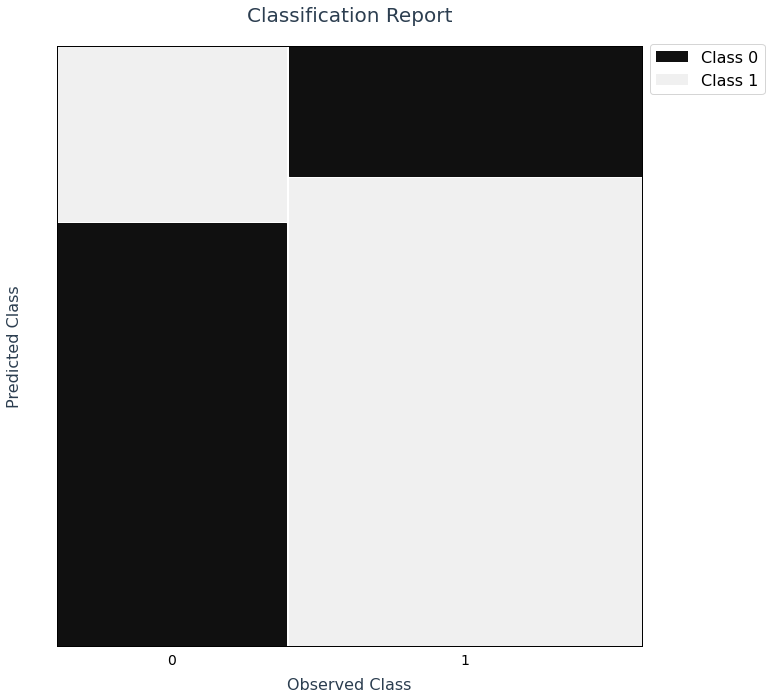

In [24]:
report.mosaic_plot()